# Week 3

This week we will start proceed to inference of model parameters (aka learning or fitting of model parameters), as well as<br>
to  preliminary model selection.

For Bayesian inference of parameters, we would like to compute the posterior distribution over model parameters, $\Theta$, given a dataset of <br>
observed spike trains:

$P(\Theta\, |\, \mathrm{data}\!=\!\{(n_t)_{t=1}^T\}, M)$

where the observed data are the set of spike trains in different trials and $M$ ($ =$ ramp or step) denotes the model. According to the Bayes rule<br>


$P(\Theta| \mathrm{data}, M) \propto P(\mathrm{data}|\Theta, M) P(\Theta| M). \qquad\qquad$             **(3.1)**

where $P(\Theta| M)$ is the prior distribution over parameters and $P(\mathrm{data}|\Theta, M)$ is the model's likelihood function.<br>
Calculating the posterior distribution is hard  in general, since the  expression on the right hand side of Eq. (3.1)<br>
is not normalized (below we will refer to this expression  as the **unnormalized posterior**), and calculating <br>
the normalization constant requires integrating or summing over the possibly high-dimensional space of parameters.  <br>
The same is true if we want to calulate the expectation of some function of parameters (e.g. $\mathbb{E}[\Theta| \text{data}, M]$):<br>
again we have to integrate over the parameters.
In general, **the computational cost of this integration grows exponentially in the number of parameters <br>
(or the dimension of parameter space)**. Thus Bayesian methods almost inevitably rely on one or another type of approximation<br>
 for calculating the posterior.

In our project, the models have only 3 unknown parameters to be inferred, and the above problem is not prohibitive. <br>
However, if, e.g., we approximate the integral by a sum over a discretized 3D grid of points, such that the grid partitions<br>
 each parameter's range of values (as determined by the prior) into, say, only $M = 10$ sub-intervals, we will have to sum <br>
over $M^3$ points, which requires $M^3 = 1000$ evaluations of the likelihood. 

In our case, at each point of the grid, the likelihood or its logarithm, can be calculated using the forward pass<br>
of the forward-backward algorithm (those curious about the details: see the section Model Log-likelihood of the [notes on the FBA](https://github.com/ahmadianlab/gg3_nda/blob/main/fwdbwd.ipynb)).<br> 
Note that this requires order $T$ matrix multiplications, each involving order $K^2$ arithmetic operations for $K$ Markov states;<br>
thus evaluation of the log-likelikehood for each value of parameters has cost $O(K^2 T)$.<br>
Thus computing the likelihood is relatively expensive (even if on our laptops it can be evaluated in a fraction of a second),<br>
and evaluating the posterior on such a grid has computational cost $O(M^d K^2 T)$, where for us $d=3$, or in some of the tasks<br>
below $d=2$.                                                                                                                

Use the function `hmm_normalizer` of `inference.py` to calculate the model **log-** likelihood using the forward pass.

**Prior distributions:**
Unless instructed otherwise, **use a uniform prior distribution on the parameters**, on specified ranges. For $\sigma$ of the ramp model<br>
it will be more sensible to use a uniform prior on its logarithm. In fact, to make things easier you should work with $\ln \sigma$, when<br>
evaluating the unnormalized posterior, and in the grid method, construct the (regular) grid for $\ln \sigma$, instead of $\sigma$ <br>
(but obviously exponentiate $\ln \sigma$ when passing to your likelihood function, and when calculating posterior estimates of the parameters<br>
calculate the posterior mean or error of the exponential of the $\ln \sigma$ values). Sensible ranges are as follows:

$\beta \in [0, 4]$

$\ln\sigma \in [\ln(0.04), \ln(4)]$

$r \in \{1,2, \ldots, 100\}$ (note that you can still further "discretize" or coarse-grain this range of integers into a fewer number of "bins".)

$m \in [0,T]$

$x_0 \in [0, 1]$

**Hyperparameters:** Unless otherwise stated, use $T = 100$ and for the ramp model: $K = 100$.

#### Note on the step model's likelihood evaluation:
Before we proceed to the tasks, a note on the $K = r$ hidden-state HMM implementation of the step model (you can ignore this note<br>
if you have opted to use the time-inhomogeneous Markov chain implementation instead). As you may have noted,<br>
the jump times in the $r$-state implementation will have a delay of $r$ steps compared to the draws form the $\mathrm{NB}(m, r)$ distribution<br>
as used in Week 1. For simulating a trial with $T$ time steps, this issue can be dealt with by a time-shift,<br>
at the expense of simulating the Markov chain for $r$ extra steps: simulate $T+r$ steps but only consider the last $T$ steps,<br>
and only generate spikes in those final $T$ steps.<br>
This week, however, we would like to evaluate the likelihoods of the two models, on the *same* set of spike trains <br>
on the interval $t = 1:T$, using the forward pass of FBA. In this case, the necessary compensation for the extra, observation-less<br>
$r$ steps can be made by the following modification to the input argument `ll` that you will pass to the function `hmm_normalizer`:  <br>

- evaluate this array as normal, as the $T \times K$ matrix of observed probabilities of $n_{1:T}$ in all possible hidden states.<br>
- then prepend $r$ rows with all elements equal to 0 to the top of this matrix to make it a $(r+T)\times K$ matrix instead.

(If curious, you can verify that this is the correct way of generalizing the forward pass to  cases with "missing observations" by inspecting<br>
the [details of the forward pass](https://github.com/ahmadianlab/gg3_nda/blob/main/fwdbwd.ipynb). Also note that this compenstation<br>
is exactly equivalent to running the forward pass on the $T$ steps with observation but using $\mathcal{T}^r \pi$ --where $\mathcal{T}$
is transition matrix--<br> as the initial Markov chain probability distribution instead of $\pi$.)





### Task 3.1
**Grid approximation**

We will start this task by fixing the value of $x_0$ to 0.2 (for both models); so we will not infer it, but  assume it known.<br>
Construct a regular 2D grid on each model's parameter space (on the ranges given above, and using $\ln \sigma$ instead of $\sigma$) with $M$ grid points along each coordinate axis,
thinking of each grid point as the center of its "assigned" sub-interval.<br> 
Start by relatively high values of $M$, e.g. $M=30$.<br>

(For one calculation of the posterior over all grid points, going to higher $M$'s is also feasible, but since you want to experiment and explore with different parameters <br>
 and hyperparameters, you should compromise on using higher values of $M$. But ultimately use your own judgement, in particular by using $M < 30$ if necessary. <br>
Similarly, in the sub-tasks below, make reasonable choices of the number of different cases of true parameters, etc., that you explore.<br> 
It is probably wise to start small-scale, in a first pass through all sub-tasks, and after you have a rough overview of computational times, inference behaviour, etc,<br> 
do  more thorough final runs going over a larger number of possibilities and/or using higher $M$ values, which would take longer to compute.)

For each model simulate a dataset of $N_{\rm trial}$ spike trains, and for each dataset, evaluate *that* model's log-likelihood on all grid points<br>
(by summing the log-likelihood of all trials), and form the *normalized* posterior by using Bayes' rule Eq. (3.1).

**3.1.1:** Visualize the (approximate) posterior on the grid (e.g. using `plt.imshow`) with a  super-imposed point representing the true parameters. <br>
Repeat for different true parameter values (within the ranges of the prior distribution) and for different number of trials (over a range from 1 to 400). <br>
Document your observations of **systematic dependence of the posterior on the number of trials**. Similarly, note **any systematic changes in behaviour for different values of the true parameters**. 

In [ ]:
# Step model ll maps
from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

## Setup ##

M = 20
N = 16
actual_m = 30
actual_r = 3
actual_x0 = 0.2

values_r = np.linspace(1, 10, M)
values_m = np.linspace(0, 100, M)
values_x0 = np.linspace(0, 1, M)

T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xs = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))

# Dataset


step = StepModel(r=actual_r, m=actual_m, x0=actual_x0, Rh=Rh)
[spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

log_prior = np.log(1/M**3)
model_ll = np.zeros((M,M,M))

for m_idx in range(M):
    for r_idx in range(M):
        for x_idx in range(M):
            m = values_m[m_idx]
            r = values_r[r_idx]
            x0 = values_x0[x_idx]

            step = StepModel(r=r, m=m, x0=x0, Rh=Rh)
            [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = step.simulate_HMM_inhomo(Ntrials=0, 
                                                                                                  T=T, 
                                                                                                  get_rate=True)

            rt = np.array([x0, 1]) * Rh * dt
            lls = poisson_logpdf(counts=counts_matrix,lambdas= rt, mask=None) # N x T x K 

            if np.isnan(lls).any():
                print(lls)

            # Model log-likelihood for N trials:
            for n in range(N):
                model_ll[m_idx, r_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                log_Ps = normalized_log_trans_matrix, 
                                                                ll = lls[n])
            if np.isnan(model_ll[m_idx, r_idx, x_idx]):
                print(normalized_log_trans_matrix)
                print(lls)

end_time = time.time()
elapsed_time = end_time - start_time

print("Takes：", elapsed_time, "s")     
            
            

In [ ]:
# convert all nan to -inf
# model_ll = np.nan_to_num(model_ll, nan=-np.inf)
# Model log-posterior
unnormalised_log_poste = model_ll + log_prior
# print(unnormalised_log_poste)

log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)

# print(model_ll)
poste = np.exp(log_poste) + 1e-16
# plt.imshow(poste+1e-16, extent=[0,100,100,1], origin='upper', norm=colors.LogNorm(vmin=1e-2, vmax=0.4))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(values_r, values_m)



# if np.isnan(poste).any():
#     print(poste)
# if np.any(np.less(poste, 0)):
#     print(poste)
poste_m = np.sum(poste,axis=(1,2)) # m is axis0, so sum over axis 1
poste_r = np.sum(poste,axis=(0,2))
poste_x0 = np.sum(poste,axis=(0,1))
## 3.1.2 ##
# Inferenced para
expected_m = np.sum(values_m * poste_m)
var_m = np.sum(poste_m * (values_m - expected_m)**2)
std_m = np.sqrt(var_m)

expected_r = np.sum(values_r * poste_r)
var_r = np.sum(poste_r * (values_r - expected_r)**2)
std_r = np.sqrt(var_r)

expected_x0 = np.sum(values_x0 * poste_x0)
var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
std_x0 = np.sqrt(var_x0)


im = ax.pcolormesh(X, Y, np.sum(poste, axis=2), cmap='viridis')

ax.plot(expected_r, expected_m, marker='o', markersize=10, color='red', label="inferred")
ax.errorbar(expected_r, expected_m, xerr=std_r, yerr=std_m, markersize=10, color='red', fmt='o', capsize=5)


# Actual para
ax.plot(actual_r, actual_m, marker='o', markersize=10, color='orange', label="actual")



# ax.set_title("Parameter Posterior map (Step)")
ax.set_xlabel("r")
ax.set_ylabel("m")
ax.legend()
fig.colorbar(im)
print(std_x0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(values_r, values_x0)
im = ax.pcolormesh(X, Y, np.sum(poste, axis=0).T, cmap='viridis')

ax.plot(expected_r, expected_x0, marker='o', markersize=10, color='red', label="inferred")
ax.errorbar(expected_r, expected_x0, xerr=std_r, yerr=std_x0, markersize=10, color='red', fmt='o', capsize=5)


# Actual para
ax.plot(actual_r, actual_x0, marker='o', markersize=10, color='orange', label="actual")



ax.set_title("Model Posterior map (Step)")
ax.set_xlabel("r")
ax.set_ylabel("x0")
ax.legend()
fig.colorbar(im)

In [ ]:
# std vs Ntrials

# Step model ll maps
from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

## Setup ##

M = 30
N = 20
actual_m = 40
actual_r = 25
actual_x0 = 0.2

values_r = np.linspace(1, 100, M)
values_m = np.linspace(0, 100, M)
values_x0 = np.linspace(0, 1, M)

T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xs = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))
values_N = [1,4,16,64]
ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
for N_idx in range(len(values_N)):
    N =  values_N[N_idx]
    for repeat in range(int(64/N*5)):        
        step = StepModel(r=actual_r, m=actual_m, x0=actual_x0, Rh=Rh)
        [spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
        counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

        log_prior = np.log(1/M**3)
        model_ll = np.zeros((M,M,M))

        for m_idx in range(M):
            for r_idx in range(M):
                for x_idx in range(M):
                    m = values_m[m_idx]
                    r = values_r[r_idx]
                    x0 = values_x0[x_idx]

                    step = StepModel(r=r, m=m, x0=x0, Rh=Rh)
                    [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = step.simulate_HMM_inhomo(Ntrials=0, 
                                                                                                          T=T, 
                                                                                                          get_rate=True)

                    rt = np.array([x0, 1]) * Rh * dt
                    lls = poisson_logpdf(counts=counts_matrix,lambdas= rt, mask=None) # N x T x K 

                    if np.isnan(lls).any():
                        print(lls)

                    # Model log-likelihood for N trials:
                    for n in range(N):
                        model_ll[m_idx, r_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                        log_Ps = normalized_log_trans_matrix, 
                                                                        ll = lls[n])
                    if np.isnan(model_ll[m_idx, r_idx, x_idx]):
                        print(normalized_log_trans_matrix)
                        print(lls)
  

        unnormalised_log_poste = model_ll + log_prior
        log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)
        
        poste = np.exp(log_poste) + 1e-16
        poste_m = np.sum(poste,axis=(1,2)) # m is axis0, so sum over axis 1
        poste_r = np.sum(poste,axis=(0,2))
        poste_x0 = np.sum(poste,axis=(0,1))
        
        expected_m = np.sum(values_m * poste_m)
        var_m = np.sum(poste_m * (values_m - expected_m)**2)
        std_m = np.sqrt(var_m)

        expected_r = np.sum(values_r * poste_r)
        var_r = np.sum(poste_r * (values_r - expected_r)**2)
        std_r = np.sqrt(var_r)

        expected_x0 = np.sum(values_x0 * poste_x0)
        var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
        std_x0 = np.sqrt(var_x0)
        
        ave_results[N_idx] += np.array([expected_m, std_m, expected_r, std_r, expected_x0, std_x0])
    ave_results[N_idx] /= int(64/N)
    
#     values_N = [1,4,16,64]
# ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
# print(ave_results)

end_time = time.time()
elapsed_time = end_time - start_time
print("Takes：", elapsed_time, "s")   


In [ ]:

plt.figure(figsize=(4, 3))

plt.plot(values_N, ave_results[:,1]/values_m[-1], label="std of m", linewidth=2)
plt.plot(values_N, ave_results[:,3]/values_r[-1], label="std of r")
plt.plot(values_N, ave_results[:,5]/values_x0[-1], label="std of x0")

plt.xscale('log')

plt.legend()
plt.xticks(values_N)

plt.show()
print(ave_results[:,3])


In [ ]:
# std vs Ntrials

# Ramp model ll maps
from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

## Setup ##

M = 20
actual_b = 1.2
actual_logs = np.log(0.5)
actual_x0 = 0.2

values_logs = np.linspace(np.log(0.04), np.log(4), M) # -3.22 - 1.386
values_b = np.linspace(0, 4, M)
values_x0 = np.linspace(0, 1, M)
K = 5
st = np.arange(K) # states
xt = st/(K-1)


T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xs = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))
values_N = [1,4,16,64]
ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
for N_idx in range(len(values_N)):
    N =  values_N[N_idx]
    for repeat in range(int(64/N*5)):        
        
        ramp = RampModel(beta=actual_b, sigma=np.exp(actual_logs), x0=actual_x0, Rh=50)
        [spikes, _, _, _, _] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)

        counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

        log_prior = np.log(1/M**3)
        model_ll = np.zeros((M,M,M))

        for b_idx in range(M):
            for s_idx in range(M):
                for x_idx in range(M):

                    b = values_b[b_idx]
                    logs = values_logs[s_idx]
                    x0 = values_x0[x_idx]

                    ramp = RampModel(beta=b, sigma=np.exp(logs), x0=x0, Rh=50)
                    [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=0, 
                                                                                                   T=T, 
                                                                                                   K=K, 
                                                                                                   get_rate=True)
                    normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC

                    lls = poisson_logpdf(counts=counts_matrix, lambdas= xt*Rh*dt, mask=None) # N x T x K 

                    # Model log-likelihood for N trials:
                    for n in range(N):
                        model_ll[b_idx, s_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                        log_Ps = normalized_log_trans_matrix, 
                                                                        ll = lls[n])


        unnormalised_log_poste = model_ll + log_prior
        log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)
        
        poste = np.exp(log_poste) + 1e-16
        poste_b = np.sum(poste,axis=(1,2)) # b is axis0, so sum over axis 1,2
        poste_logs = np.sum(poste,axis=(0,2))
        poste_x0 = np.sum(poste,axis=(0,1))
        
        expected_b = np.sum(values_b * poste_b)
        var_b = np.sum(poste_b * (values_b - expected_b)**2)
        std_b = np.sqrt(var_b)

        expected_logs = np.sum(values_logs * poste_logs)
        var_logs = np.sum(poste_logs * (values_logs - expected_logs)**2)
        std_logs = np.sqrt(var_logs)

        expected_x0 = np.sum(values_x0 * poste_x0)
        var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
        std_x0 = np.sqrt(var_x0)
        
        ave_results[N_idx] += np.array([expected_b, std_b, expected_logs, std_logs, expected_x0, std_x0])
    ave_results[N_idx] /= int(64/N)
    
#     values_N = [1,4,16,64]
# ave_results = np.zeros((len(values_N),6)) # for 4 different N, expected para and std: [m,r,x0]
# print(ave_results)

end_time = time.time()
elapsed_time = end_time - start_time
print("Takes：", elapsed_time, "s")   


In [ ]:

plt.figure(figsize=(4, 3))
# actual_b = 1.2
# actual_logs = np.log(0.5)
# actual_x0 = 0.2
plt.plot(values_N, ave_results[:,1]/values_b[-1], label="std of b")
plt.plot(values_N, ave_results[:,3]/values_logs[-1], label="std of log(sigma)")
plt.plot(values_N, ave_results[:,5]/values_x0[-1], label="std of x0")

plt.xscale('log')

plt.legend()
plt.xticks(values_N,values_N)
plt.show()


In [ ]:
# Ramp model ll maps

import time

start_time = time.time()

## Setup ##
M=20
values_logs = np.linspace(np.log(0.04), np.log(4), M) # -3.22 - 1.386
values_b = np.linspace(0, 4, M)
values_x0 = np.linspace(0, 1, M)



T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xr = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))

# Dataset
actual_b = 1
actual_logs = np.log(0.1)
actual_x0 = 0.2
N = 16
K = 50
st = np.arange(K) # states
xt = st/(K-1)

ramp = RampModel(beta=actual_b, sigma=np.exp(actual_logs), x0=actual_x0, Rh=50)
[spikes, _, _, _, _] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)

counts_matrix = generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=True, return_counts=True);


log_prior = np.log(1/M**3)
model_ll = np.zeros((M,M,M))

for b_idx in range(M):
    for s_idx in range(M):
        for x_idx in range(M):

            b = values_b[b_idx]
            logs = values_logs[s_idx]
            x0 = values_x0[x_idx]

            ramp = RampModel(beta=b, sigma=np.exp(logs), x0=x0, Rh=50)
            [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=0, 
                                                                                           T=T, 
                                                                                           K=K, 
                                                                                           get_rate=True)
            normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC

            lls = poisson_logpdf(counts=counts_matrix, lambdas= xt*Rh*dt, mask=None) # N x T x K 

            # Model log-likelihood for N trials:
            for n in range(N):
                model_ll[b_idx, s_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                log_Ps = normalized_log_trans_matrix, 
                                                                ll = lls[n])


unnormalised_log_poste = model_ll + log_prior
log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)

poste = np.exp(log_poste) + 1e-16
poste_b = np.sum(poste,axis=(1,2)) # b is axis0, so sum over axis 1,2
poste_logs = np.sum(poste,axis=(0,2))
poste_x0 = np.sum(poste,axis=(0,1))

expected_b = np.sum(values_b * poste_b)
var_b = np.sum(poste_b * (values_b - expected_b)**2)
std_b = np.sqrt(var_b)

expected_logs = np.sum(values_logs * poste_logs)
var_logs = np.sum(poste_logs * (values_logs - expected_logs)**2)
std_logs = np.sqrt(var_logs)

expected_x0 = np.sum(values_x0 * poste_x0)
var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
std_x0 = np.sqrt(var_x0)
        

end_time = time.time()
elapsed_time = end_time - start_time

print("Takes：", elapsed_time, "s")     

In [ ]:


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(np.exp(values_logs), values_b)
im = ax.pcolormesh(X, Y, np.sum(poste,axis=2), cmap='viridis')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.set_xticks([0.04, 0.4, 4],[0.04, 0.4, 4])# 0.4, 1])
# ax.set_xticklabels(['0.04','0.4', '4'])


err_s = np.array([[np.exp(expected_logs - std_logs)],[np.exp(expected_logs + std_logs) ]])
plt.plot(np.exp(expected_logs), expected_b, marker='o', markersize=10, color='red', label="inferred")
plt.errorbar(np.exp(expected_logs), expected_b, xerr=err_s, yerr=std_b, markersize=10, color='red', fmt='o', capsize=5)


# Actual para
plt.plot(np.exp(actual_logs), actual_b, marker='o', markersize=10, color='orange', label="actual")



ax.set_title("Model Posterior map (Ramp)")
ax.set_xlabel("sigma")
ax.set_ylabel("beta")
# plt.xticks(range(M), [1, 25, 50, 75, 100])
# plt.yticks(range(M), [0, 25, 50, 75, 100])
ax.legend()
fig.colorbar(im) #, shrink=0.25)


In [ ]:
# # Step model ll maps, 3D inference
# # {m, r, x0}

# from models import *
# from models2 import *
# from inference import *
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.ticker as ticker

# import time

# start_time = time.time()

# ## Setup ##

# M = 10
# N = 20
# actual_m = 50
# actual_r = 40


# values_r = np.linspace(1, 100, M)
# values_m = np.linspace(0, 100, M)
# values_x = np.linspace(0, 1, M)


# T=100
# time_points = np.linspace(1,T,T) # 0,1,2,...
# dt = 1/T
# time_ms = time_points * dt * 1e3

# Rh = 50
# xs = 0.2
# bin_size = 20
# bin_size_2 = 50
# bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# # plt.figure(figsize=(5, 3))

# # Dataset


# step = StepModel(r=actual_r, m=actual_m, x0=xs, Rh=Rh)
# [spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
# counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);

# log_prior = np.log(1/M)
# model_ll = np.zeros((M,M,M))
# for m_idx in range(M):
#     for r_idx in range(M):
#         for x_idx in range(M):
#             m = values_m[m_idx]
#             r = values_r[r_idx]
#             xs = values_x[x_idx]

#             step = StepModel(r=r, m=m, x0=xs, Rh=Rh)
#             [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = step.simulate_HMM_inhomo(Ntrials=1, T=T, get_rate=True)

#             rt = np.array([xs, 1]) * Rh * dt
#             # ll: nt ~ Poission(st/(k-1) * Rh * dt)
#             # lls: ll for N trials. lls[0] to get ll of first trial
#             lls = poisson_logpdf(counts=counts_matrix,lambdas= rt, mask=None) # N x T x K 

#             if np.isnan(lls).any():
#                 print(lls)

#             # Model log-likelihood for N trials:
#             for n in range(N):
#                 model_ll[m_idx, r_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, log_Ps = normalized_log_trans_matrix, ll = lls[n])
#             if np.isnan(model_ll[m_idx, r_idx, x_idx]):
#                 print(normalized_log_trans_matrix)

# end_time = time.time()
# elapsed_time = end_time - start_time

# print("Takes：", elapsed_time, "s")     
            
            

In [ ]:
# # convert all nan to -inf
# # model_ll = np.nan_to_num(model_ll, nan=-np.inf)
# # Model log-posterior
# unnormalised_log_poste = model_ll + log_prior
# # print(unnormalised_log_poste)

# log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)

# # print(model_ll)
# poste = np.exp(log_poste) + 1e-16
# # plt.imshow(poste+1e-16, extent=[0,100,100,1], origin='upper', norm=colors.LogNorm(vmin=1e-2, vmax=0.4))

# fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# X, Y = np.meshgrid(values_r, values_m)
# im = ax.pcolormesh(X, Y, poste, cmap='viridis', norm=colors.LogNorm(vmin=1e-2, vmax=0.4))

# # if np.isnan(poste).any():
# #     print(poste)
# # if np.any(np.less(poste, 0)):
# #     print(poste)
# poste_m = np.sum(poste,axis=1) # m is axis0, so sum over axis 1
# poste_r = np.sum(poste,axis=0)
# ## 3.1.2 ##
# # Inferenced para
# expected_m = np.sum(values_m * poste_m)
# var_m = np.sum(poste_m * (values_m - expected_m)**2)
# std_m = np.sqrt(var_m)


# expected_r = np.sum(values_r * poste_r)
# var_r = np.sum(poste_r * (values_r - expected_r)**2)
# std_r = np.sqrt(var_r)

# print(std_r)

# ax.plot(expected_r, expected_m, marker='o', markersize=10, color='red', label="inferred")
# ax.errorbar(expected_r, expected_m, xerr=std_r, yerr=std_m, markersize=10, color='red', fmt='o', capsize=5)


# # Actual para
# ax.plot(actual_r, actual_m, marker='o', markersize=10, color='orange', label="actual")



# ax.set_title("Model Posterior map (Step)")
# ax.set_xlabel("r")
# ax.set_ylabel("m")
# ax.legend()
# fig.colorbar(im)

**3.1.2:** In addition to visualisation, evaluate the posterior expectations of the parameters as their estimates, as well as their posterior standard deviations (as measures of their
posterior uncertainties or  "error bars" for their estimates).  **Given the true parameter value, you can also evaluate the actual estimation error of different parameters, 
for  dataset of different sizes (different number of trials) or choices of true parameters (averaging the error over a few, even just 2-3, datasets when $N_{trial}$ is low).**
Make appropriate plots. 

Also quantitatively compare the estimation errors with the posterior uncertainties of different parameters. 
What do you expect for this relationship, and what do you observe?

**3.1.3:** Repeat the above (using judgment to scale down $M$ or the number of explored cases) for the case where $x_0$ is unknown as well, and has to be inferred.

### Task 3.2
**Model selection (grid based)**

Repeat the sub-tasks in Task 3.1, for the two "cross-cases" where you compute the posterior and posterior expectations of one models's parameters,<br>
given spike-trains generated by the other model. How do things change in each case? Document any interesting observations of systematic behaviour.

In [ ]:
# 3.1.2

# std


Takes： 8.798432111740112 s
evidence= -1386.0054605191656


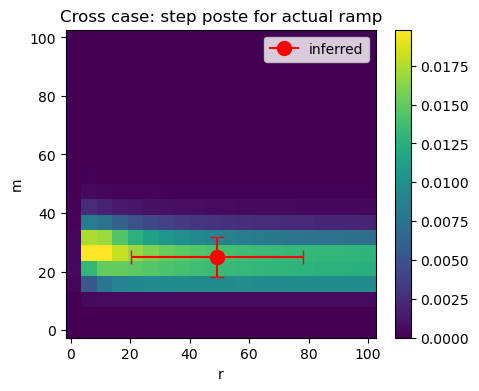

In [248]:
# Cross case 1
# Actual: Ramp
# Posterior: Step


import time

start_time = time.time()

## Setup ##
M=20
values_logs = np.linspace(np.log(0.04), np.log(4), M) # -3.22 - 1.386
values_b = np.linspace(0, 4, M)
values_r = np.linspace(1, 100, M)
values_m = np.linspace(0, 100, M)
values_x0 = np.linspace(0, 1, M)

T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50

bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)

# plt.figure(figsize=(5, 3))

# Dataset

N = 16
K = 100
st = np.arange(K) # states
xt = st/(K-1)

# generate dataset
actual_b = 1.6
actual_logs = np.log(0.1)
actual_x0 = 0.3

ramp = RampModel(beta=actual_b, sigma=np.exp(actual_logs), x0=actual_x0, Rh=50)
[spikes, _, _, _, _] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)
counts_matrix = generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=True, return_counts=True);


log_prior = np.log(1/M**3)
model_ll = np.zeros((M,M,M))

for m_idx in range(M):
    for r_idx in range(M):
        for x_idx in range(M):
            m = values_m[m_idx]
            r = values_r[r_idx]
            x0 = values_x0[x_idx]

            step = StepModel(r=r, m=m, x0=x0, Rh=Rh)
            [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = step.simulate_HMM_inhomo(Ntrials=0, 
                                                                                                  T=T, 
                                                                                                  get_rate=True)

            rt = np.array([x0, 1]) * Rh * dt
            lls = poisson_logpdf(counts=counts_matrix,lambdas= rt, mask=None) # N x T x K 

            if np.isnan(lls).any():
                print(lls)

            # Model log-likelihood for N trials:
            for n in range(N):
                model_ll[m_idx, r_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                log_Ps = normalized_log_trans_matrix, 
                                                                ll = lls[n])
            if np.isnan(model_ll[m_idx, r_idx, x_idx]):
                print(normalized_log_trans_matrix)
                print(lls)


# convert all nan to -inf
model_ll = np.nan_to_num(model_ll, nan=-np.inf)

# Model log-posterior
unnormalised_log_poste = model_ll + log_prior
# print(unnormalised_log_poste)
MLL = logsumexp_scipy(unnormalised_log_poste)
log_poste = unnormalised_log_poste - MLL
poste = np.exp(log_poste) + 1e-16
# plt.imshow(poste+1e-16, extent=[0,100,100,1], origin='upper', norm=colors.LogNorm(vmin=1e-2, vmax=0.4))

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(values_r, values_m)

poste_m = np.sum(poste,axis=(1,2)) # m is axis0, so sum over axis 1
poste_r = np.sum(poste,axis=(0,2))
poste_x0 = np.sum(poste,axis=(0,1))
## 3.1.2 ##
# Inferenced para
expected_m = np.sum(values_m * poste_m)
var_m = np.sum(poste_m * (values_m - expected_m)**2)
std_m = np.sqrt(var_m)

expected_r = np.sum(values_r * poste_r)
var_r = np.sum(poste_r * (values_r - expected_r)**2)
std_r = np.sqrt(var_r)

expected_x0 = np.sum(values_x0 * poste_x0)
var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
std_x0 = np.sqrt(var_x0)


im = ax.pcolormesh(X, Y, np.sum(poste, axis=2), cmap='viridis')
ax.plot(expected_r, expected_m, marker='o', markersize=10, color='red', label="inferred")
ax.errorbar(expected_r, expected_m, xerr=std_r, yerr=std_m, markersize=10, color='red', fmt='o', capsize=5)

# No actual para
# plt.plot(actual_logs, actual_b, marker='o', markersize=10, color='orange', label="actual")



ax.set_title("Cross case: step poste for actual ramp")
ax.set_xlabel("r")
ax.set_ylabel("m")
ax.legend()
fig.colorbar(im)

end_time = time.time()
elapsed_time = end_time - start_time

print("Takes：", elapsed_time, "s")     
print("evidence=",MLL)

Takes： 26.47672986984253 s
0.6129137514249913


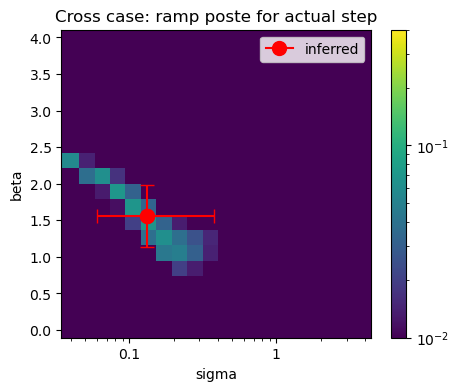

In [250]:
# Cross case 2
# Actual: Step
# Posterior: Ramp

from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

import time

start_time = time.time()

## Setup ##

M = 20
N = 16
K = 20

actual_m = 50
actual_r = 3
actual_x0 = 0.5
# actual_b = 1.5
# actual_logs = np.log(0.5)

values_r = np.linspace(1, 10, M)
values_m = np.linspace(0, 100, M)
values_logs = np.linspace(np.log(0.04), np.log(4), M) # -3.22 - 1.386
values_b = np.linspace(0, 4, M)
values_x0 = np.linspace(0, 1, M)


T=100
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3

Rh = 50
xs = 0.2
xr = 0.2
bin_size = 20
bin_size_2 = 50
bin_edges = np.arange(0, 1e3+bin_size, bin_size)
st = np.arange(K) # states
xt = st/(K-1)

# actual_b = 1.5
# actual_logs = np.log(0.5)


step = StepModel(r=actual_r, m=actual_m, x0=actual_x0, Rh=Rh)
[spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
# generate actual step dataset
counts_matrix= generate_psth(spike_trains=spikes, bin_size=bin_size, bin_size_2=bin_size_2, plot=False, return_counts=True);
log_prior = np.log(1/M**3)
model_ll = np.zeros((M,M,M))

for b_idx in range(M):
    for s_idx in range(M):
        for x_idx in range(M):

            b = values_b[b_idx]
            logs = values_logs[s_idx]
            x0 = values_x0[x_idx]

            ramp = RampModel(beta=b, sigma=np.exp(logs), x0=x0, Rh=50)
            [_, _, _, normalized_log_trans_matrix, normalized_log_pi0] = ramp.simulate_HMM(Ntrials=0, 
                                                                                           T=T, 
                                                                                           K=K, 
                                                                                           get_rate=True)
            normalized_log_trans_matrix = normalized_log_trans_matrix[np.newaxis, :, :] # (1,K,K) for homogeneous MC

            lls = poisson_logpdf(counts=counts_matrix, lambdas= xt*Rh*dt, mask=None) # N x T x K 

            # Model log-likelihood for N trials:
            for n in range(N):
                model_ll[b_idx, s_idx, x_idx] += hmm_normalizer(log_pi0 = normalized_log_pi0, 
                                                                log_Ps = normalized_log_trans_matrix, 
                                                                ll = lls[n])

end_time = time.time()
elapsed_time = end_time - start_time

print("Takes：", elapsed_time, "s")     

# convert all nan to -inf
model_ll = np.nan_to_num(model_ll, nan=-np.inf)

# Model log-posterior
unnormalised_log_poste = model_ll + log_prior
# print(unnormalised_log_poste)

log_poste = unnormalised_log_poste - logsumexp_scipy(unnormalised_log_poste)
poste = np.exp(log_poste)+1e-16


fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(np.exp(values_logs), values_b)
im = ax.pcolormesh(X, Y, np.sum(poste,axis=2), cmap='viridis', norm=colors.LogNorm(vmin=1e-2, vmax=0.4))
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
# ax.set_xticks([0.04, 0.4, 4])# 0.4, 1])
# ax.set_xticklabels(['0.04','0.4', '4'])


poste = np.exp(log_poste) + 1e-16
poste_b = np.sum(poste,axis=(1,2)) # b is axis0, so sum over axis 1,2
poste_logs = np.sum(poste,axis=(0,2))
poste_x0 = np.sum(poste,axis=(0,1))

expected_b = np.sum(values_b * poste_b)
var_b = np.sum(poste_b * (values_b - expected_b)**2)
std_b = np.sqrt(var_b)

expected_logs = np.sum(values_logs * poste_logs)
var_logs = np.sum(poste_logs * (values_logs - expected_logs)**2)
std_logs = np.sqrt(var_logs)

expected_x0 = np.sum(values_x0 * poste_x0)
var_x0 = np.sum(poste_x0 * (values_x0 - expected_x0)**2)
std_x0 = np.sqrt(var_x0)
        
print(std_logs)
err_s = np.array([[np.exp(expected_logs - std_logs)],[np.exp(expected_logs + std_logs) ]])
plt.plot(np.exp(expected_logs), expected_b, marker='o', markersize=10, color='red', label="inferred")
plt.errorbar(np.exp(expected_logs), expected_b, xerr=err_s, yerr=std_b, markersize=10, color='red', fmt='o', capsize=5)


# No actual para for cross case
# plt.plot(np.exp(actual_logs), actual_b, marker='o', markersize=10, color='orange', label="actual")



ax.set_title("Cross case: ramp poste for actual step")
ax.set_xlabel("sigma")
ax.set_ylabel("beta")
# plt.xticks(range(M), [1, 25, 50, 75, 100])
# plt.yticks(range(M), [0, 25, 50, 75, 100])
ax.legend()
fig.colorbar(im) #, shrink=0.25)   

One (or, arguably, the) Bayesian method for model selection is the computation of so-called Bayes factors, i.e. the model posteriors (for $M = $ ramp or step):

$P(M| \mathrm{data}) \propto P(\mathrm{data}| M) P(M)$

where $P(M)$ denotes the prior probability of each model (and $\mathrm{data}=\{(n_t)_{t=1}^T\}$), which we will take to be 0.5 throughout. In this case, the posterior<br>
model probabilities are proportional to their so-called **marginal likelihoods** $P(\mathrm{data}| M)$, and model selection can be entirely based on the **marginal likelihood ratio (MLR)**: <br>

$R = \frac{P(\mathrm{data}| M=ramp)}{P(\mathrm{data}| M=step)}\qquad\qquad$     **(3.2)**

or its logarithm, with the ramp model chosen if $R>1$ or $\ln R > 0$, and vice versa.

$P(\mathrm{data}| M)$ is called marginal likelihood because its calculation involves integrating out (or marginalizing) model parameters:

$P(\mathrm{data}| M) = \int P(\mathrm{data}|\Theta, M) P(\Theta| M)\, d\Theta.\qquad\qquad$   **(3.3)**

Comparison with Eq. (3.1) shows that this is *exactly* the normalizing constant (the denominator of Bayes rule) for the unnormalized posterior over model parameters. <br>
(The denominator of the Bayes rule 3.1, is also known as "evidence", as it quantifies the strength of evidence in favor of the model.)<br>
So you have already evaluated the marignal likelihoods in Task 3.1 when you normalized the posteriors (up to approximating the integral with a sum over grid points).<br>
(**However,** you need to make sure that you have included the appropriate (approximate) $d\Theta$'s in the formula. This is the volume of each square in your grid, and for 
integer $r$ the number of integers within the coarse-grid, if using a coars-grid. Also note that this depends on your choice of normalization of the prior; ultimately what 
matters is that if you replace $P(\mathrm{data}|\Theta, M)$ in Eq. (3.3) with 1, the integral or grid-sum should evaluate to 1.)

In [ ]:
# Tool for calculating MLR


from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import time


start_time = time.time()


## generate dataset ##

actual_model = "step"
N = 20
T=100
K=100

if actual_model == "ramp":
    actual_b = 1.5
    actual_logs = np.log(0.5)
    actual_x0 = 0.2
    ramp = RampModel(beta=actual_b, sigma=np.exp(actual_logs), x0=actual_x0, Rh=50)
    [spikes, _, _, _, _] = ramp.simulate_HMM(Ntrials=N, T=T, K=K, get_rate=True)
    counts_matrix = generate_psth(spike_trains=spikes, return_counts=True);

elif actual_model == "step":
    actual_m = 50
    actual_r = 100
    actual_x0 = 0.2
    step = StepModel(r=actual_r, m=actual_m, x0=actual_x0, Rh=50)
    [spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
    counts_matrix= generate_psth(spike_trains=spikes, return_counts=True);

end_time = time.time()
elapsed_time = end_time - start_time
print("Actual model: ", actual_model)
print("Dataset generated: ", elapsed_time, "s")   


logMLR, ramp_MLL, step_MLL = MLR_calculator(counts_matrix, M = 10, K = 10, Print=False)


print(logMLR, np.where(logMLR > 0, 'ramp', 'step'))

In [3]:
from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import time

In [1]:
accuracy = classifier_tester(M=10, N=10, classifier="mlr") # M: number of datasets for each model
print("accuracy = ", accuracy)

2x10 datasets generated (NxT = 10x100)： 0.003280162811279297 s
Pridictions generated： 38.0385160446167 s
accuracy =  0.65


Do model selection, based on the MLR, for datasets of different sizes (number of trials) and quantify the two different error rates. <br>

- **3.2.1:** First do this by sampling the **("true") parameters**, used for generating a dataset from each model, from that model's prior parameter distribution. <br> 
- **3.2.2:** Repeat this with **"mismatched" parameter** priors: for data-generation, **sample parameters from distributions other than the priors used in inference** (you may, in particular, use non-uniform distributions). What happens to the error rates? Investigate and document this for different degrees of deviation between the data-generation distribution and the priors. 

In [ ]:
# 0->Step, 1->Ramp
# def generate_test_spike_trains(M=20, N=400, T=100, rmin=1, rmax=100, 
#                                bmin=0, bmax=4, logsmin=0.04, logsmax=4, 
#                                mmin=0, mmax=100, xmin=0, xmax=1,
#                                model="original", GammaShape=None):
start_time = time.time()
N=40
M=100 # num of datasets
T=100

data_points = generate_test_spike_trains(M=M, N=N, T=T, model="hmm")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"2x{M} datasets generated (NxT = {N}x{T})：", elapsed_time, "s")     

start_time = time.time()
predictions, _ = MLR_classifier(data_points)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Pridictions generated：", elapsed_time, "s")     

accuracy = (np.sum(1-predictions[0]) + np.sum(predictions[1]))/(2*M)

print(f"accuracy for step={np.sum(1-predictions[0])/M}, for ramp={np.sum(predictions[1])/M}")

2x100 datasets generated (NxT = 40x100)： 7.532484769821167 s
Pridictions generated： 942.6583712100983 s
accuracy for step=0.88, for ramp=0.97


In [5]:
# Examine the upper limit of MLL=1/M**3 (M is num of grid) for step
# 0->Step, 1->Ramp
# def generate_test_spike_trains(M=20, N=400, T=100, rmin=1, rmax=100, 
#                                bmin=0, bmax=4, logsmin=0.04, logsmax=4, 
#                                mmin=0, mmax=100, xmin=0, xmax=1,
#                                model="original", GammaShape=None):


N=10

# Do nor change:

from models import *
from models2 import *
from inference import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import time
num_grid = 10
K = 20 # K for ramp inference
T=100
start_time = time.time()
time_points = np.linspace(1,T,T) # 0,1,2,...
dt = 1/T
time_ms = time_points * dt * 1e3
Rh = 50
values_r = np.linspace(1, 10, num_grid)
values_m = np.linspace(0, 100, num_grid)
values_logs = np.linspace(np.log(0.04), np.log(4),num_grid) # -3.22 - 1.386
values_b = np.linspace(0, 4, num_grid)
values_x0 = np.linspace(0, 1, num_grid)

logMLRs = np.zeros((num_grid,num_grid))
ramp_MLLs = np.zeros((num_grid,num_grid))
step_MLLs = np.zeros((num_grid,num_grid))
x0 = 0.2
num=0

for m_idx in range(num_grid):
    for r_idx in range(num_grid):
#             for x_idx in range(num_grid):
        m = values_m[m_idx]
        r = values_r[r_idx]
#                 x0 = values_x0[x_idx]
        step = StepModel(r=r, m=m, x0=x0, Rh=Rh)
        [step_spikes, _, _, _, _] = step.simulate_HMM_inhomo(Ntrials=N, T=T, get_rate=True)
        counts_matrix= generate_psth(spike_trains=step_spikes, return_counts=True);
        logMLR, ramp_MLL, step_MLL = MLR_calculator(counts_matrix, M = num_grid, K = K, Print=True)
        logMLRs[m_idx,r_idx]=logMLR
        ramp_MLLs[m_idx,r_idx]= ramp_MLL
        step_MLLs[m_idx,r_idx]=step_MLL
        end_time = time.time()
        elapsed_time = end_time - start_time
        num+=1
        print(f"{num}/{num_grid**2}, {elapsed_time} s")

Ramp marginal log-likelihood inferred： 2.095484972000122 s
Step marginal log-likelihood inferred： 0.834467887878418 s
1/100, 2.933621883392334 s
Ramp marginal log-likelihood inferred： 2.225898027420044 s
Step marginal log-likelihood inferred： 0.8412539958953857 s
2/100, 6.002312898635864 s
Ramp marginal log-likelihood inferred： 2.079730987548828 s
Step marginal log-likelihood inferred： 0.8582069873809814 s
3/100, 8.941784143447876 s
Ramp marginal log-likelihood inferred： 2.304874897003174 s
Step marginal log-likelihood inferred： 0.93392014503479 s
4/100, 12.182291984558105 s
Ramp marginal log-likelihood inferred： 2.1531097888946533 s
Step marginal log-likelihood inferred： 0.8234128952026367 s
5/100, 15.1609468460083 s
Ramp marginal log-likelihood inferred： 2.050049066543579 s
Step marginal log-likelihood inferred： 0.8040640354156494 s
6/100, 18.01660394668579 s
Ramp marginal log-likelihood inferred： 2.0208489894866943 s
Step marginal log-likelihood inferred： 0.797421932220459 s
7/100, 

Ramp marginal log-likelihood inferred： 2.0451478958129883 s
Step marginal log-likelihood inferred： 0.7998089790344238 s
57/100, 163.7239580154419 s
Ramp marginal log-likelihood inferred： 2.0227408409118652 s
Step marginal log-likelihood inferred： 0.8165900707244873 s
58/100, 166.56798887252808 s
Ramp marginal log-likelihood inferred： 2.0387158393859863 s
Step marginal log-likelihood inferred： 0.8059279918670654 s
59/100, 169.41843581199646 s
Ramp marginal log-likelihood inferred： 2.0611093044281006 s
Step marginal log-likelihood inferred： 0.7988638877868652 s
60/100, 172.28382205963135 s
Ramp marginal log-likelihood inferred： 2.03489089012146 s
Step marginal log-likelihood inferred： 0.803839921951294 s
61/100, 175.12954902648926 s
Ramp marginal log-likelihood inferred： 2.02017879486084 s
Step marginal log-likelihood inferred： 0.7984466552734375 s
62/100, 177.95348191261292 s
Ramp marginal log-likelihood inferred： 2.056030035018921 s
Step marginal log-likelihood inferred： 0.807726860046

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


step precision: 77.0%, n: 4


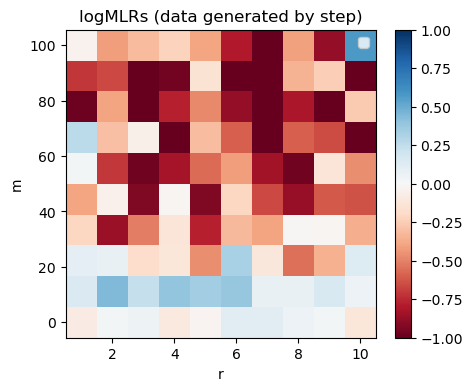

In [4]:
ave_logMLRs = logMLRs/N
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
X, Y = np.meshgrid(values_r, values_m)
im = ax.pcolormesh(X, Y, ave_logMLRs, cmap='RdBu', vmin=-1, vmax=1)

ax.set_title("logMLRs (data generated by step)")
ax.set_xlabel("r")
ax.set_ylabel("m")
# plt.xticks(range(M), [1, 25, 50, 75, 100])
# plt.yticks(range(M), [0, 25, 50, 75, 100])
ax.legend()
fig.colorbar(im) #, shrink=0.25)   

print(f"step precision: {np.sum(ave_logMLRs < 0)/num_grid**2*100}%, n: {N}")